In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt

sys.path.append("..")
import src

%matplotlib inline

In [3]:
src.set_random_seed(42)
src.util.download_data()

In [4]:
reduced_train_labels = ['bird', 'deer', 'truck']

In [5]:
ts = src.util.timestamp()
run_name = "conv_only_with_flip_and_denoise"
outdir = "../checkpoints/{}_{}".format(run_name, ts)
outfilename = os.path.join(outdir, "autoencoder_{}".format(ts))
print("Out file: {}".format(outfilename))
datasets = src.data.get_datasets(reduced_train_labels, do_random_hflip=True)
train_data, valid_data, test_data = datasets

conv_layers = [(32, 1, 0),
               (32, 2, 0),
               (32, 2, 0)]
               
linear_layers = [(2048, 0.5)]

Out file: ../checkpoints/conv_only_with_flip_and_denoise_20200329_235128/autoencoder_20200329_235128
42500 training samples, 5000 validation samples, 5000 test samples


In [6]:
autoencoder, autoencoder_losses = src.train.train_autoencoder(conv_layers,
                                                  linear_layers,
                                                  train_data,
                                                  valid_data,
                                                  batch_norm=True,
                                                  batch_size=64,
                                                  valid_stop_count=5,
                                                  lr = 1e-2,
                                                  noise_std=0.3
                                                 )
os.makedirs(outdir, exist_ok=True)
torch.save(autoencoder.state_dict(), outfilename)
src.train.test_autoencoder(autoencoder, test_data, 256)

AutoEncoder(
  (encoder_conv): Sequential(
    (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_0): ReLU()
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout_0): Dropout(p=0)
    (conv_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_1): ReLU()
    (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout_1): Dropout(p=0)
    (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_2): ReLU()
    (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout_2): Dropout(p=0)
  )
  (encoder_linear): Sequential(
    (linear_0): Linear(in_features=2048, out_

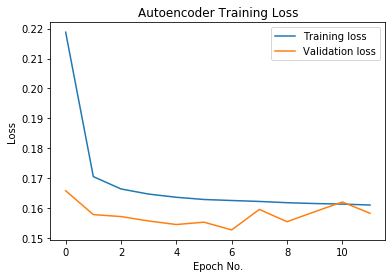

In [7]:
src.util.plot_losses(autoencoder_losses, "Autoencoder Training Loss", "./autoencoder_losses.png")

In [8]:
h = 4
w = 4
idxs = np.random.randint(len(test_data), size=h*w)
sample_images = [test_data[i][0] for i in idxs]
autoencode_results = []
for img in sample_images:
    model_input = torch.Tensor(img).reshape((1, 3, 32, 32)).cuda()
    autoencode_results.append(autoencoder(model_input).reshape(3, 32, 32).detach().cpu())


../src/util.py:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  grid = np.vstack((make_row(i*w, (i+1)*w) for i in range(h)))
../src/util.py:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.hstack(convert_for_imshow(images[i]) for i in range(l, r))


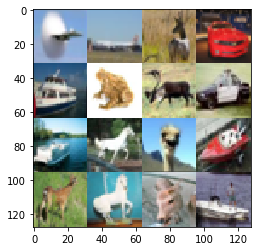

In [9]:
src.util.show_grid_images(h, w, sample_images, "input_grid.png")

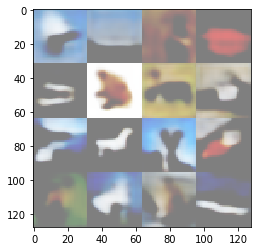

In [10]:
src.util.show_grid_images(h, w, autoencode_results, "output_grid.png")

In [15]:
src.train.get_autoencoder_losses_per_class(autoencoder, test_data)

Label: airplane, Mean Loss: 0.09
Label: automobile, Mean Loss: 0.19
Label: bird, Mean Loss: 0.14
Label: cat, Mean Loss: 0.17
Label: deer, Mean Loss: 0.15
Label: dog, Mean Loss: 0.16
Label: frog, Mean Loss: 0.18
Label: horse, Mean Loss: 0.16
Label: ship, Mean Loss: 0.12
Label: truck, Mean Loss: 0.16
Total Mean Loss: 0.15


In [11]:
ts = src.util.timestamp()

try:
    use_autoencoder = autoencoder
except:
    # In case kernel was interrupted load from checkpoint
    use_autoencoder = src.autoencoder.AutoEncoder(conv_layers, [], batch_norm = True)
    autoencoder_checkpoint = "../checkpoints/conv_only_with_flip_and_denoise_20200329_135833/autoencoder_20200329_135833"
    use_autoencoder.load_state_dict(torch.load(autoencoder_checkpoint))

ac_outfilename = os.path.join(outdir, "autoencoder_classifier_{}".format(ts))
print("Out file: {}".format(ac_outfilename))
classifier_hidden_sizes = [(256, 0.5)]
auto_class, auto_class_losses = src.train.train_autoencoder_classifier(use_autoencoder,
                                                            classifier_hidden_sizes,
                                                            train_data,
                                                            valid_data,
                                                            batch_norm = True,
                                                            batch_size=64,
                                                            valid_stop_count = 5)
os.makedirs(outdir, exist_ok=True)
torch.save(auto_class.state_dict(), ac_outfilename)
src.train.test_classifier(auto_class, test_data, 256)


Out file: ../checkpoints/conv_only_with_flip_and_denoise_20200329_235128/autoencoder_classifier_20200329_235501
AutoEncoder_Based_Classifier(
  (encoder_conv): Sequential(
    (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_0): ReLU()
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout_0): Dropout(p=0)
    (conv_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_1): ReLU()
    (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout_1): Dropout(p=0)
    (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_2): ReLU()
    (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

0.7884

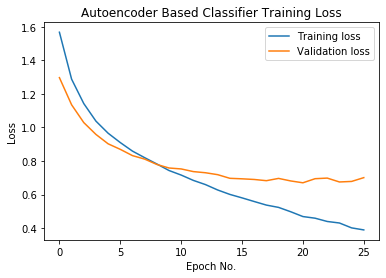

In [12]:
src.util.plot_losses(auto_class_losses, "Autoencoder Based Classifier Training Loss", "./auto_class_losses.png")

In [13]:
ctrl_classifier, ctrl_classifier_losses = src.train.train_classifier(conv_layers,
                                                     linear_layers + classifier_hidden_sizes,
                                                     train_data,
                                                     valid_data,
                                                     batch_norm = True,
                                                     batch_size=64,
                                                     valid_stop_count = 5)
src.train.test_classifier(ctrl_classifier, test_data, 256)

Classifier(
  (conv_layers): Sequential(
    (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_relu_0): ReLU()
    (conv_dropout_0): Dropout(p=0)
    (conv_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_relu_1): ReLU()
    (conv_maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_dropout_1): Dropout(p=0)
    (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_relu_2): ReLU()
    (conv_maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_dropout_2): Dropout(p=0)
  )
  (hidden_layers): Seque

0.8042

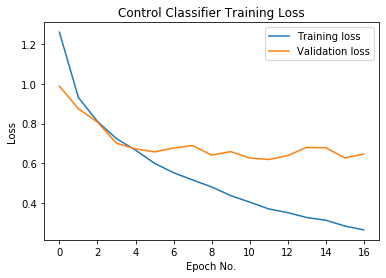

In [14]:
src.util.plot_losses(ctrl_classifier_losses, "Control Classifier Training Loss", "./ctrl_class_losses.png")